In [4]:
# Envirnoment: pymc5_cyg python3.12.7
# https://www.pymc.io/projects/examples/en/latest/howto/updating_priors.html

import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from scipy import stats
from tqdm.notebook import trange

az.style.use("arviz-white")

%config InlineBackend.figure_format = "retina"

In [5]:
rng: np.random.Generator = np.random.default_rng(seed=42)

In [7]:
# True parameter values
alpha_true = 5
beta0_true = 7
beta1_true = 13
sigma_true = 2

# Size of dataset
size = 100

# Predictor variable
X1 = rng.normal(size=size)
X2 = rng.normal(size=size) * 0.2

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 + beta1_true * X2 + rng.normal(size=size, scale=sigma_true)
Y_true = alpha_true + beta0_true * X1 + beta1_true * X2

In [12]:
# plt.plot(X1, Y, "C0.")
# plt.plot(X1, Y_true, "k.")

In [13]:
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta0 = pm.Normal("beta0", mu=0, sigma=5)
    beta1 = pm.Normal("beta1", mu=0, sigma=5)

    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta0 * X1 + beta1 * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # draw 2_000 posterior samples
    trace = pm.sample(
        tune=1_500, draws=2_000, target_accept=0.9, progressbar=False, random_seed=rng
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 4 seconds.


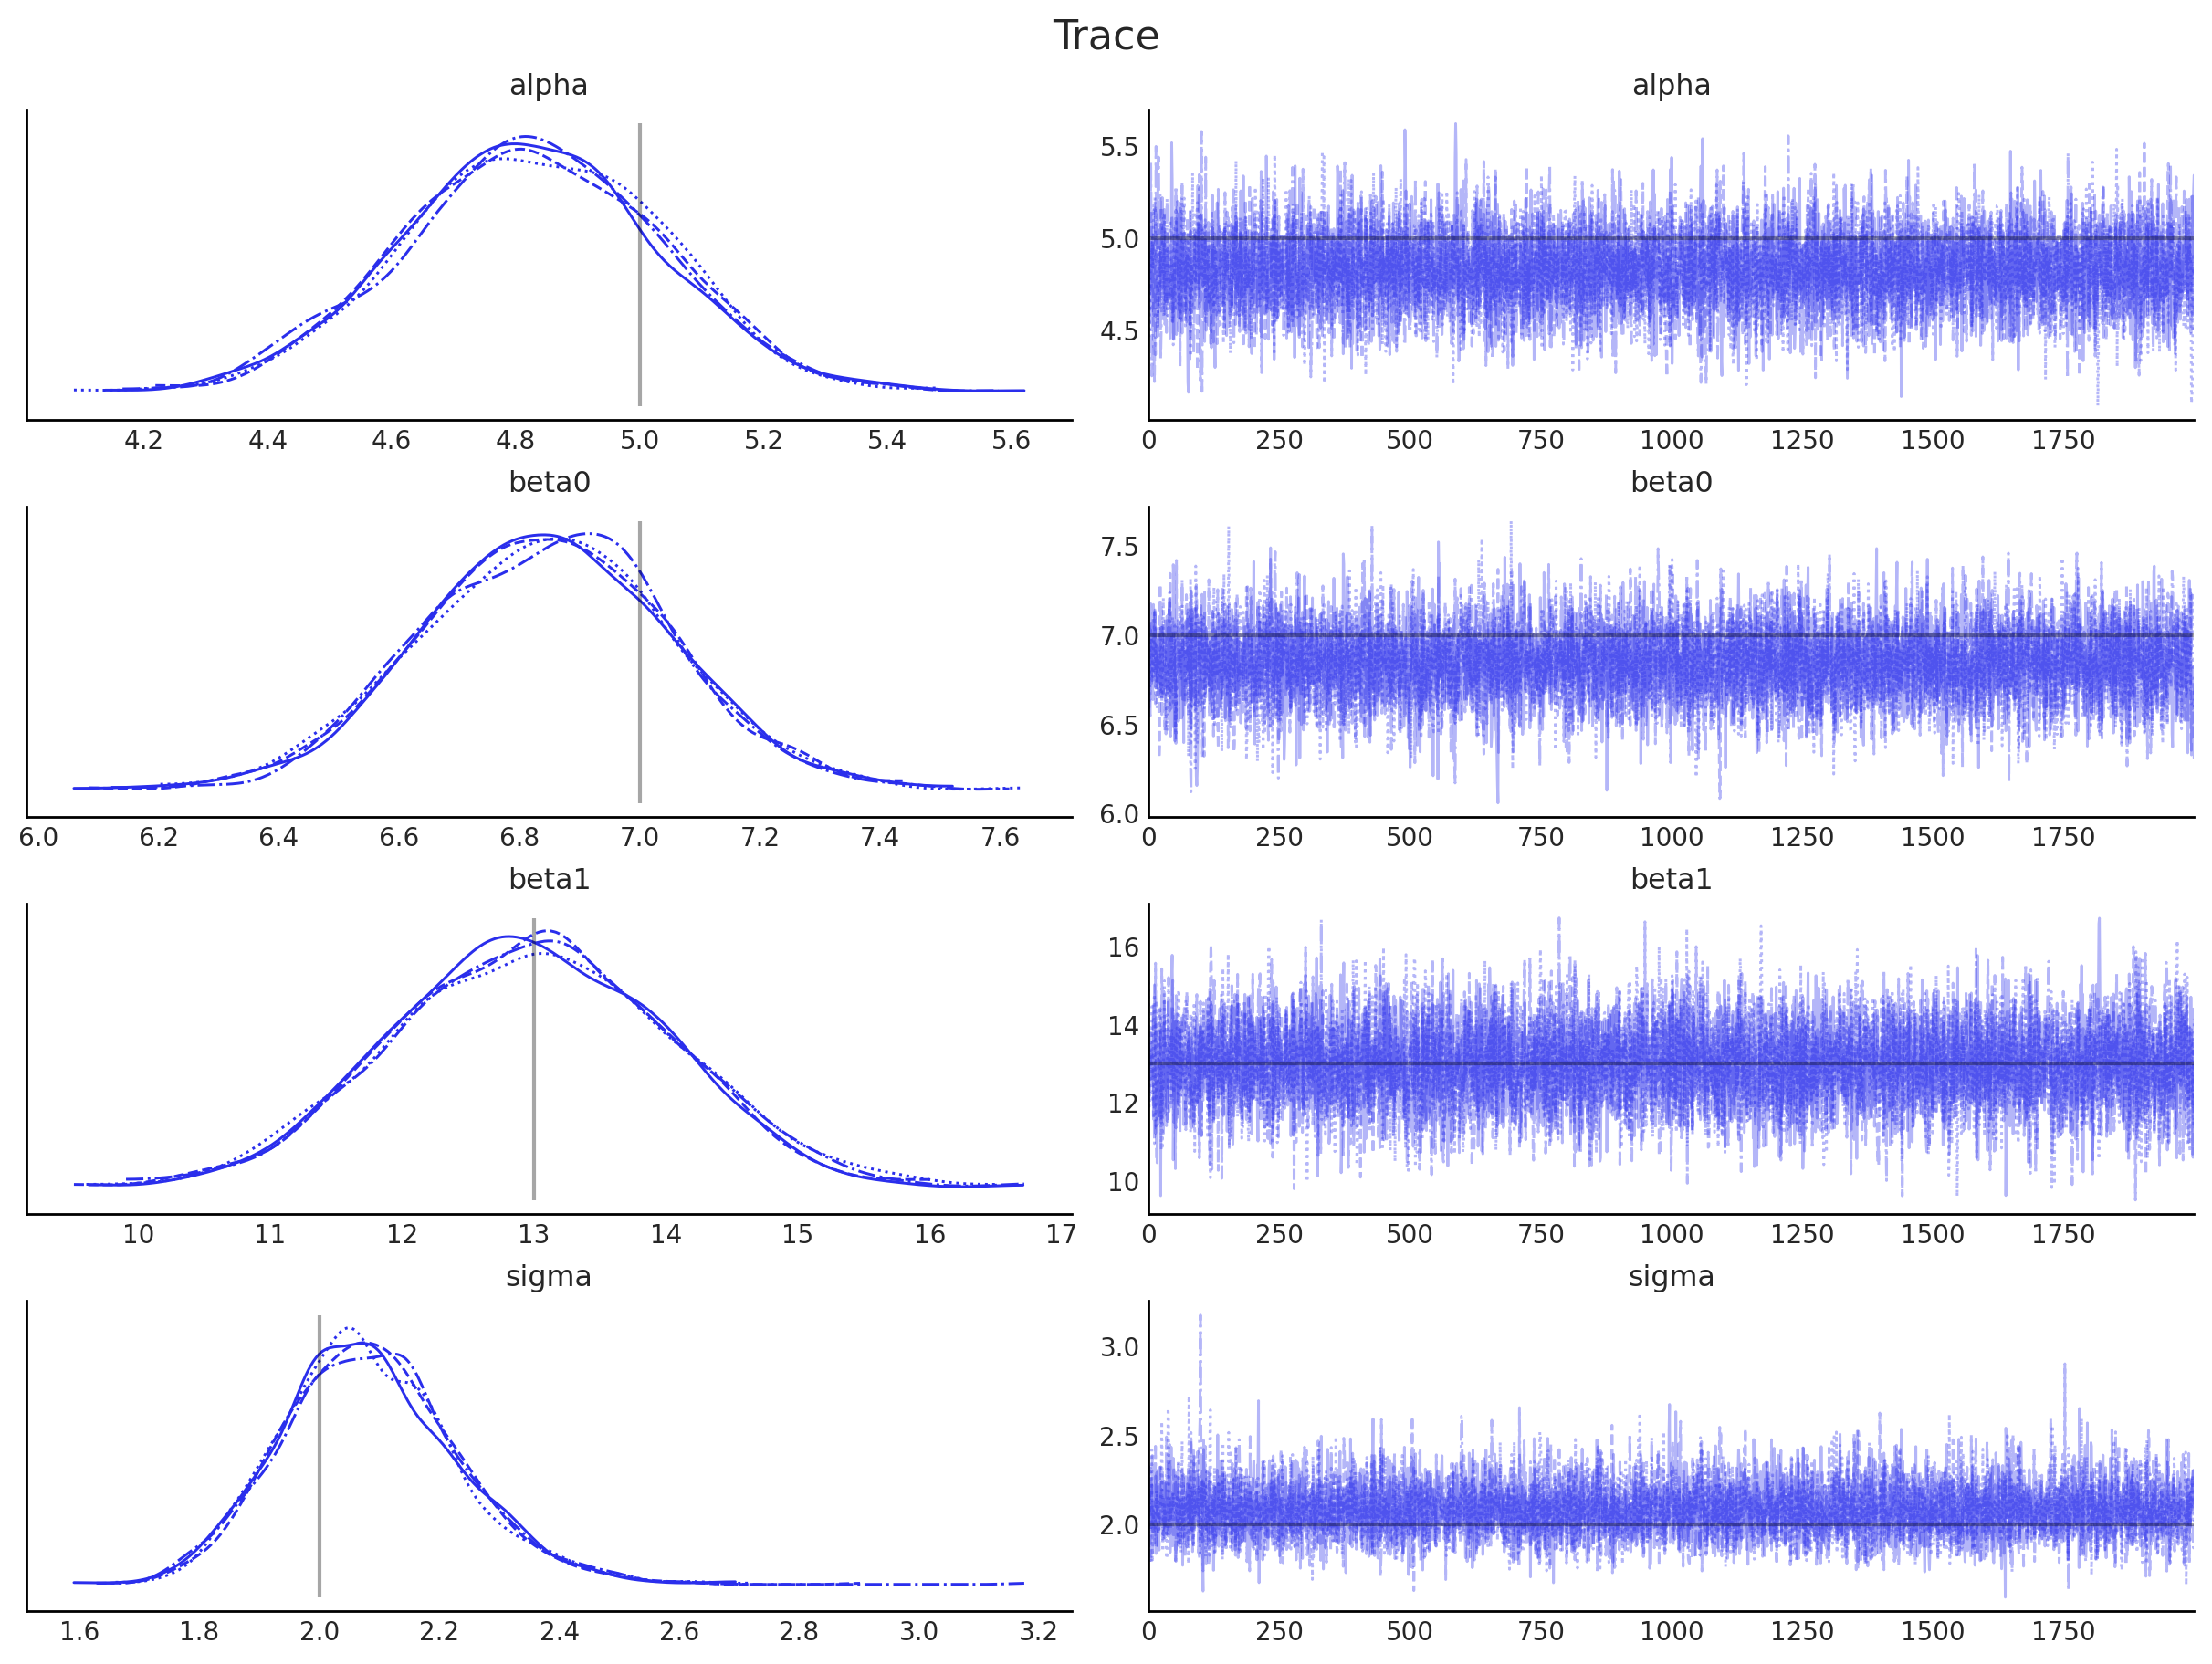

In [14]:
axes = az.plot_trace(
    data=trace,
    compact=True,
    lines=[
        ("alpha", {}, alpha_true),
        ("beta0", {}, beta0_true),
        ("beta1", {}, beta1_true),
        ("sigma", {}, sigma_true),
    ],
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16);

In [15]:
def from_posterior(param, samples):
    smin, smax = samples.min().item(), samples.max().item()
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(param, x, y)

In [16]:
traces = [trace]

In [17]:
n_iterations = 10

for _ in trange(n_iterations):
    # generate more data
    X1 = rng.normal(size=size)
    X2 = rng.normal(size=size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + rng.normal(size=size, scale=sigma_true)

    with pm.Model() as model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior("alpha", az.extract(trace, group="posterior", var_names=["alpha"]))
        beta0 = from_posterior("beta0", az.extract(trace, group="posterior", var_names=["beta0"]))
        beta1 = from_posterior("beta1", az.extract(trace, group="posterior", var_names=["beta1"]))
        sigma = from_posterior("sigma", az.extract(trace, group="posterior", var_names=["sigma"]))

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

        # draw 2_000 posterior samples
        trace = pm.sample(
            tune=1_500, draws=2_000, target_accept=0.9, progressbar=False, random_seed=rng
        )
        traces.append(trace)

  0%|          | 0/10 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for d

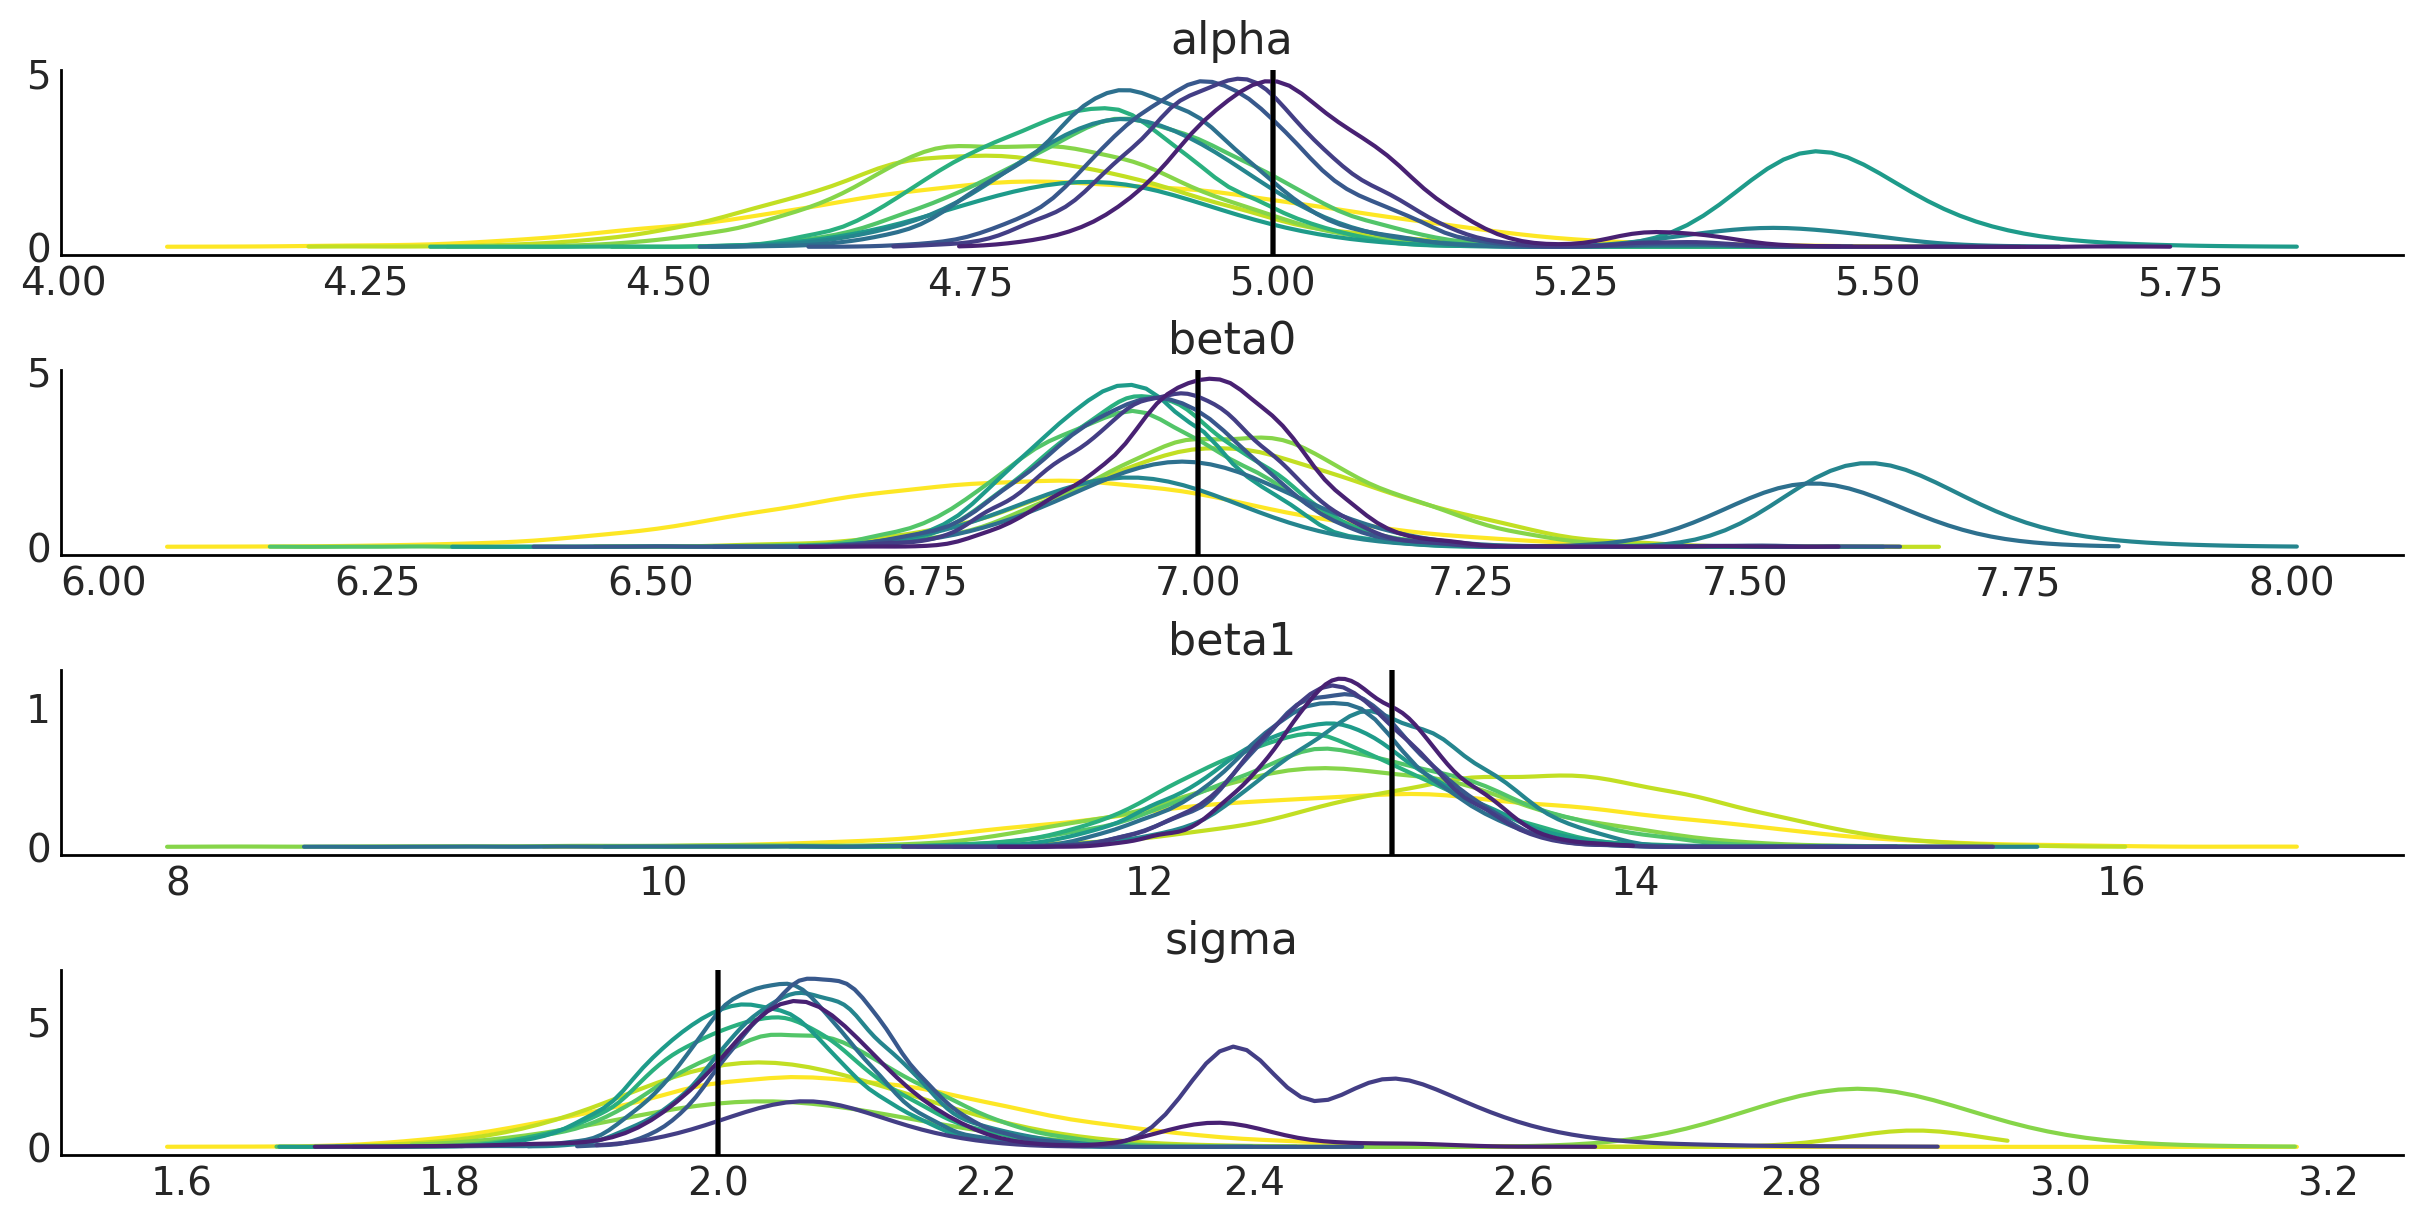

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,6), sharex=False, sharey=False)

cmap = mpl.cm.viridis

for i, (param, true_value) in enumerate(
    zip(["alpha", "beta0", "beta1", "sigma"], [alpha_true, beta0_true, beta1_true, sigma_true])
):
    for update_i, trace in enumerate(traces):
        samples = az.extract(trace, group="posterior", var_names=param)
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        ax[i].plot(x, y, color=cmap(1 - update_i / len(traces)))
        ax[i].axvline(true_value, c="k")
        ax[i].set(title=param)